# Playing with some audio

## Imports

In [20]:
%matplotlib inline
import wave
import sys
from pprint import pprint

import numpy as np
from matplotlib import pyplot as plt

Once we got that out of the way, let's _start plotting_ – just for fun.

Let's take $f: [0, 100] \rightarrow \mathbb R, x \mapsto x^2$

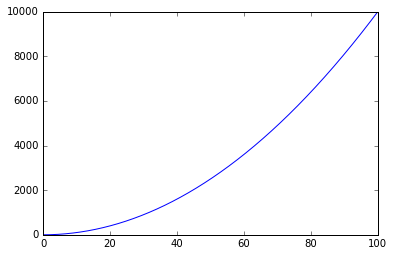

In [21]:
xs = np.arange(0, 100, 0.01)
y = lambda x: x**2

plt.plot(xs, [y(x) for x in xs])

## Decoding

Now, onto the real business:  We need to decode that wavefile. Currently, it is assumed to be at `sample.wav`.

The file is assumed to not be using any compression and using basic [PCM](https://en.wikipedia.org/wiki/Pulse-code_modulation).

With these assumptions, the python wave module enables us to read each frame of the sound part.  A frame represents one point of audio information.  If the file uses the standard $44.1~kHz$ framerate, $n$ seconds of sound are encoded by $n \cdot 44100$ of such frames.

### Structure of the Frames
Each frame successively contains a _sample_ for each channel of the file. The number of channels is specified in the file header. We easily gain access over the most important header-information via the [Wave_read.getparams()](https://docs.python.org/3/library/wave.html#wave.Wave_read.getparams) method.

Samples are assumed to be encoded as `signed int`s using little endian, i.e. the most significant bit (highest power of $2$) is at the beginning, as you are used to from reading binary representations of numbers.

The following method decodes a frame into two such `int`s.  (To be more precise, it is a [generator](https://docs.python.org/3/tutorial/classes.html#generators) successively yielding each sample in a one-shot manner. To persist it, we need to convert it using `tuple` or similiar).

In [22]:
def iter_decode_frame(frame, channels=1):
    """Decode a WAV frame into a tuple of signed ints
    
    :param frame: a bytes-like object of length divisible by
    `channels`
    
    :param channels: the number of channels contained in
    this frame
    
    :returns: a tuple of length `channels` consisting the integer
    representation of the bytes. It assumes

    :raises: ValueError if `len(frame)` not divisible by `channels`
    
    >>> tuple(decode_frame(b'\x7f'))
    (127,)

    >>> tuple(decode_frame(b'\xff'))
    (-1,)
    
    >>> tuple(decode_frame(b'\x7f \x7e \xfd, \x00', channels=4))
    (127, 126, -3, 0)
    """
    sample_length = len(frame) / channels
    if not sample_length.is_integer():
        raise ValueError("len(frame) not divisible by {}".format(channels))
    sample_length = int(sample_length)
    
    for channel in range(channels):
        offset = channel * sample_length
        sample_bytes = frame[offset:offset + sample_length]
        sample = int.from_bytes(sample_bytes, byteorder='little',
                                signed=True)       
        yield sample

## Reading the Data

Alright, let's finally read that file.  We use `wave.open` to receive a `Wave_read` object and read each frame via `readframes(1)`, until the length of the current frame is zero, which happens at the end.

In [23]:
data = [[], []]

with wave.open("test.wav") as read:
    framerate = read.getframerate()
    params = read.getparams()
    for i in range(params.nframes):
        current_frame = read.readframes(1)

        if len(current_frame) != params.nchannels * params.sampwidth:
            print("Got a frame of length {0} at frame {1} of {2}, breaking.\n"
                  .format(len(current_frame), i, params.nframes))
            break
            

        current_samples = iter_decode_frame(current_frame,
                                            channels=params.nchannels)
        for channel, sample_int in enumerate(current_samples):
            data[channel].append(sample_int)
            
print("Metadata of the wave object:\n{}\n".format(params))
ch1, ch2, *_ = data
print("First values of each channel:")
pprint(ch1[:10])
pprint(ch2[:10])

Metadata of the wave object:
_wave_params(nchannels=2, sampwidth=3, framerate=44100, nframes=192437, comptype='NONE', compname='not compressed')

First values of each channel:
[0, -303, -3064, -6143, -33774, -22760, -17757, -21861, -14090, -25155]
[0, 100, 4703, -4663, 534, 18375, 1686, -3091, 6967, 4929]


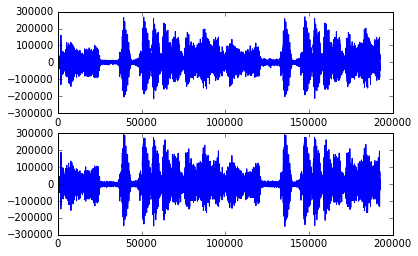

In [24]:
def plot_channels(*channels, start=0, end=None):
    frames = len(channels[0])
    
    # iff any channel's length differs from channel[0] (⇒bool() == True),
    # not all channels have equal length.
    if any(len(channel) - frames
           for channel in channels):
        raise ValueError("All channels must have the same length")
        
    t = np.arange(frames)
    if end is None:
        end = len(channels[0])

    plt.title("Audio data over {0} frames".format(end-start+1))
    
    for cell, channel in enumerate(channels, start=1):
        plot = plt.subplot(len(channels), 1, cell)
        plot.plot(t[start:end], channel[start:end])

# frame_range = params.nframes  # 2 * framerate
plot_channels(ch1, ch2) 

__Hooray!__

This is now some great basis to play around with. :-)